In [1]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, GridSearchCV

from utils import plot_contour

2024-04-21 18:51:50.747619: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 18:51:50.780043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 18:51:51.268379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
train_filename = "data_oneleak_train(stratify)_without_outliers"
test_filename = "data_oneleak_test(stratify)_without_outliers"

In [20]:
df_train = pd.read_csv(f"./data/{train_filename}.csv")
df_test = pd.read_csv(f"./data/{test_filename}.csv")

points_fill = np.array(np.loadtxt("./data/fill.csv"))
points_contour = np.array(np.loadtxt("./data/contour.csv"))

In [21]:
x_train, x_test, y_train, y_test = df_train[["y1","y2"]], df_test[["y1","y2"]], np.array(tf.argmax(df_train.iloc[:,:10].values, axis=1)) + 1, np.array(tf.argmax(df_test.iloc[:,:10].values, axis=1)) + 1

In [22]:
clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("decision-tree", tree.DecisionTreeClassifier(random_state=42))]
)

In [23]:
# Define the parameters for grid search
param_grid = {
    'decision-tree__criterion': ['gini', 'entropy'],
    'decision-tree__max_depth': [None, 5, 10, 15, 20],
    'decision-tree__min_samples_split': [2, 5, 10],
    'decision-tree__min_samples_leaf': [1, 2, 4],
}

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('decision-tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decision-tree__criterion': ['gini', 'entropy'],
                         'decision-tree__max_depth': [None, 5, 10, 15, 20],
                         'decision-tree__min_samples_leaf': [1, 2, 4],
                         'decision-tree__min_samples_split': [2, 5, 10]})

In [24]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'decision-tree__criterion': 'gini', 'decision-tree__max_depth': None, 'decision-tree__min_samples_leaf': 1, 'decision-tree__min_samples_split': 2}
Best Score: 0.9516961299569996


In [25]:
start = time.time()

# Use the best parameters found by grid search
best_decision_tree_params = grid_search.best_params_

# Extract the relevant parameters for DecisionTreeClassifier
best_decision_tree_clf = tree.DecisionTreeClassifier(**{key.split('__')[1]: value for key, value in best_decision_tree_params.items() if 'decision-tree' in key}, random_state=42)

# Define the pipeline with the best parameters
best_clf = Pipeline(steps=[("scaler", StandardScaler()), ("decision-tree", best_decision_tree_clf)])

# Fit the pipeline with the best parameters to the training data
best_clf.fit(x_train, y_train)

# Evaluate the performance of the best classifier
accuracy = best_clf.score(x_test, y_test)
print("Accuracy of the best classifier on test set: {:.2f}".format(accuracy))

end = time.time()

Accuracy of the best classifier on test set: 0.96


In [26]:
train_sizes, train_scores, valid_scores = learning_curve(best_clf, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 20), cv=5)

In [27]:
def accuracy(y_pred,y_true):
    return np.sum(y_pred==y_true)*100/len(y_pred)

In [28]:
y_pred = best_clf.predict(x_test)

In [29]:
training_accuracy = accuracy(best_clf.predict(x_train),y_train)
print(f"Training accuracy for decision tree is: {round(training_accuracy,2)}")

Training accuracy for decision tree is: 100.0


In [30]:
acc = accuracy(y_pred=y_pred,y_true=y_test)
print(f"The accuracy for decision trees is {round(acc,2)}")

The accuracy for decision trees is 96.08


In [31]:
print(f"Time required to fit the model: {end-start} seconds.")

Time required to fit the model: 0.006457805633544922 seconds.


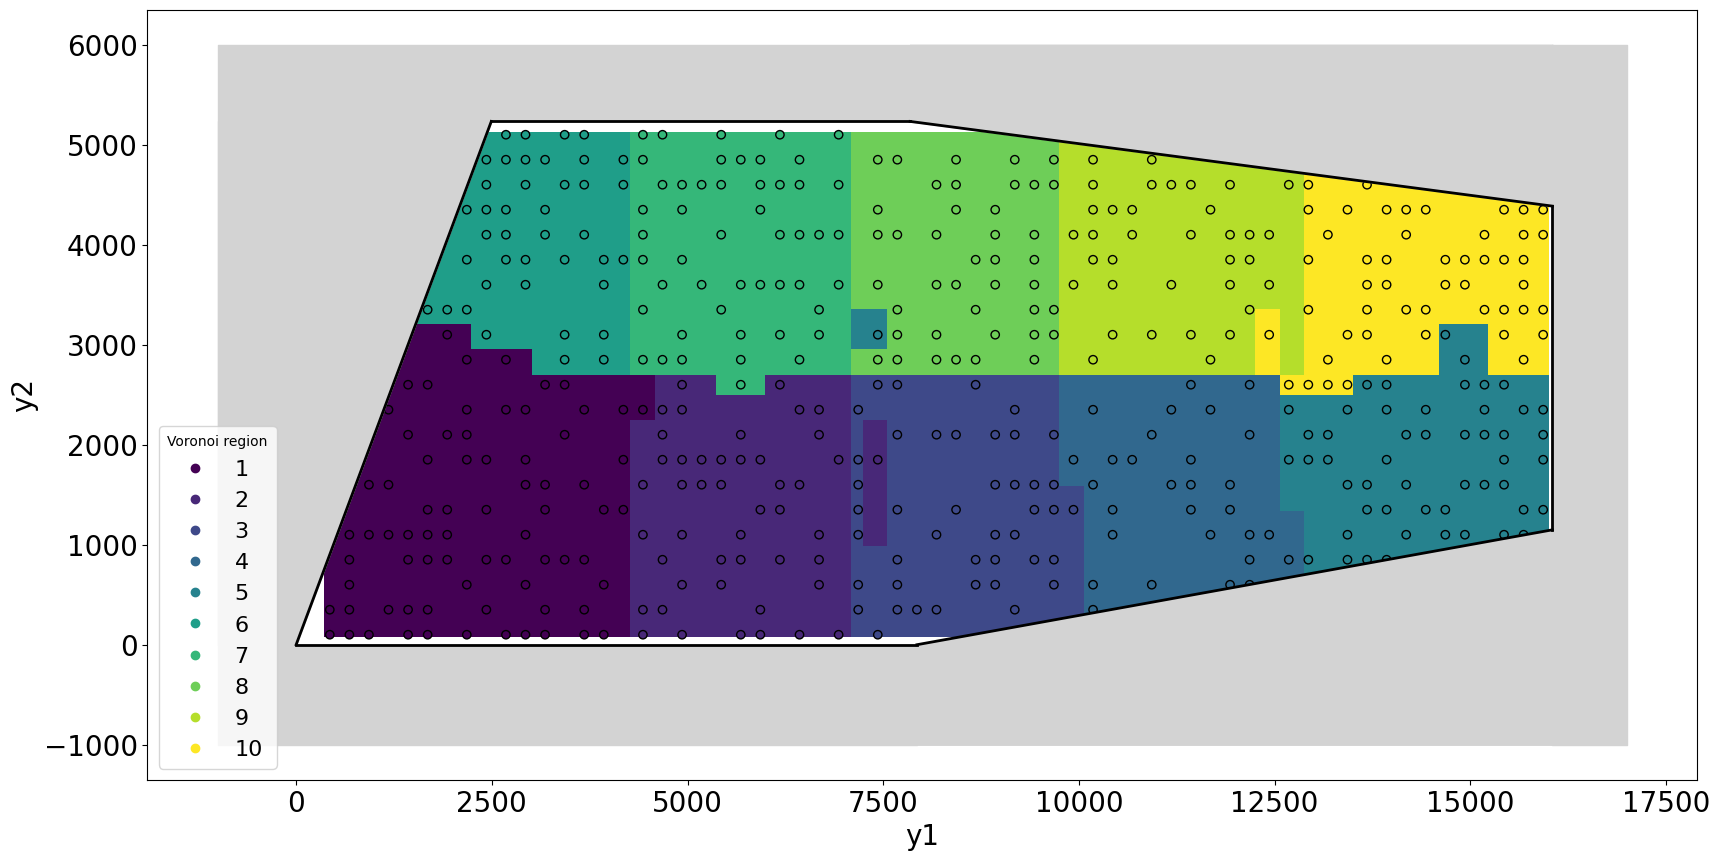

In [32]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 10))

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)

plot_contour(points_contour,points_fill)

disp = DecisionBoundaryDisplay.from_estimator(
    best_clf,
    x_train,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="y1",
    ylabel="y2",
    shading="auto",
    ax=axs
)
scatter = disp.ax_.scatter(x_train.iloc[:, -2], x_train.iloc[:, -1], c=y_train, edgecolors="k")
disp.ax_.legend(
    scatter.legend_elements()[0],
    list(set(y_train)),
    loc="lower left",
    title="Voronoi region",
)
# _ = disp.ax_.set_title(
#     f"10-Class classification for Training data with outliers using Decision Trees.\nAccuracy = {round(training_accuracy,2)}\n{train_filename}.csv"
# )

plt.show()

In [ ]:
fig.savefig(f"./plots/Final/Stratify/With outliers/Decision_trees_training.png")

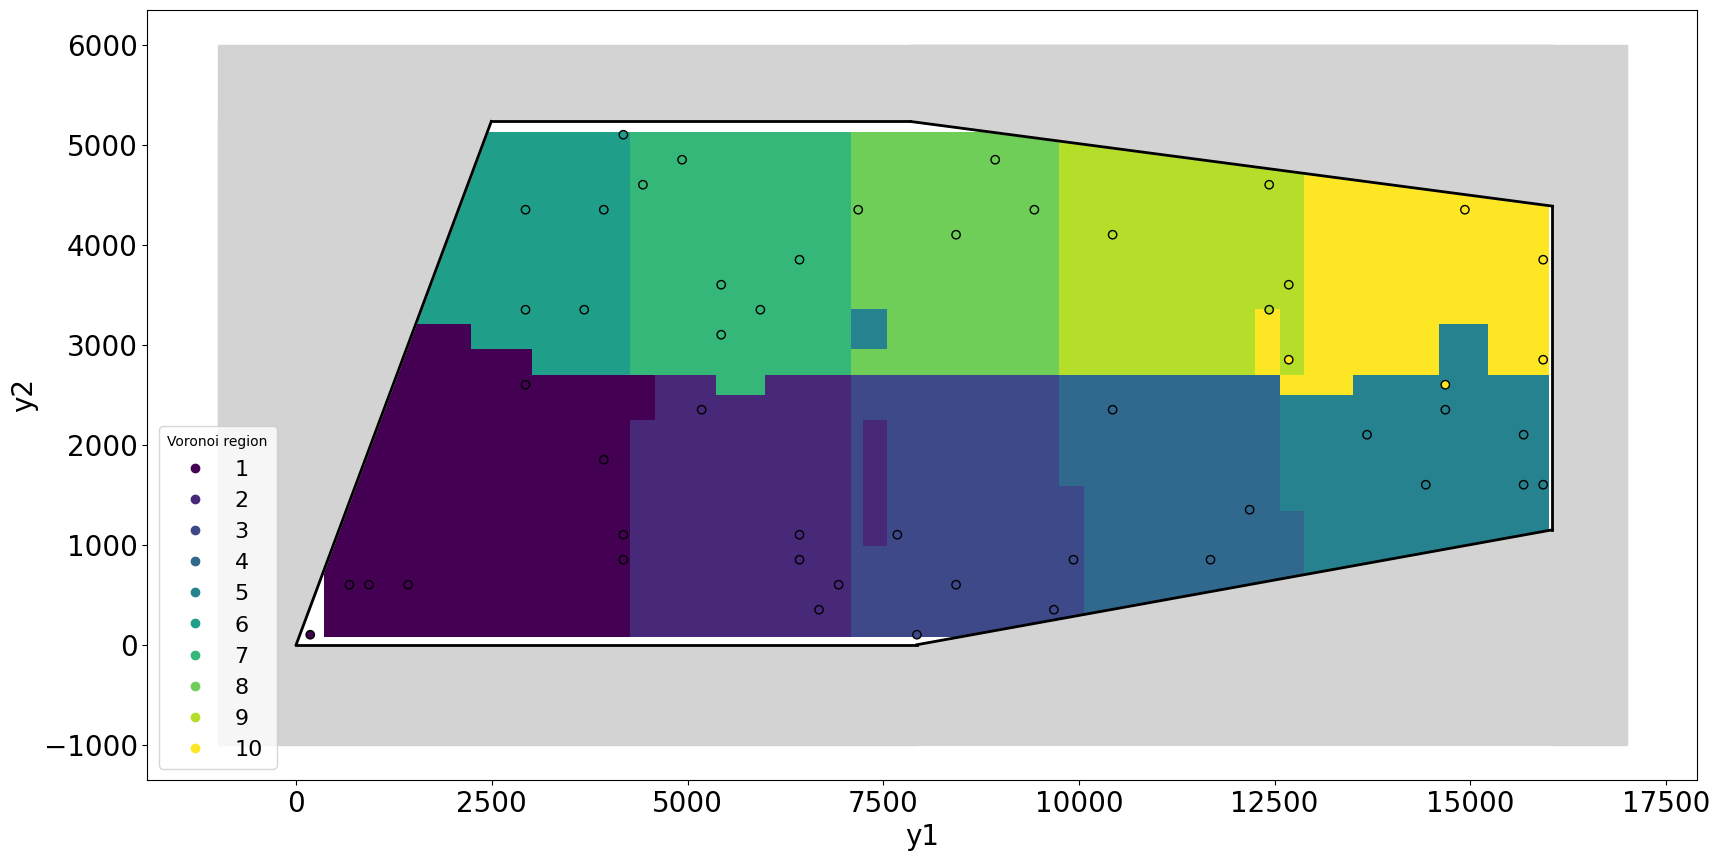

In [33]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 10))
plot_contour(points_contour,points_fill)

disp = DecisionBoundaryDisplay.from_estimator(
    best_clf,
    x_train,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="y1",
    ylabel="y2",
    shading="auto",
    ax=axs
)
scatter = disp.ax_.scatter(x_test.iloc[:, 0], x_test.iloc[:, 1], c=y_test, edgecolors="k")

disp.ax_.legend(
    scatter.legend_elements()[0],
    list(set(y_test)),
    loc="lower left",
    title="Voronoi region",
)
# _ = disp.ax_.set_title(
#     f"10-Class classification for Testing data with outliers using Decision Trees.\nAccuracy={round(acc,2)}\n{test_filename}.csv"
# )

plt.show()


In [35]:
fig.savefig(f"./plots/Final/Stratify/With outliers/Decision_trees_testing.png")


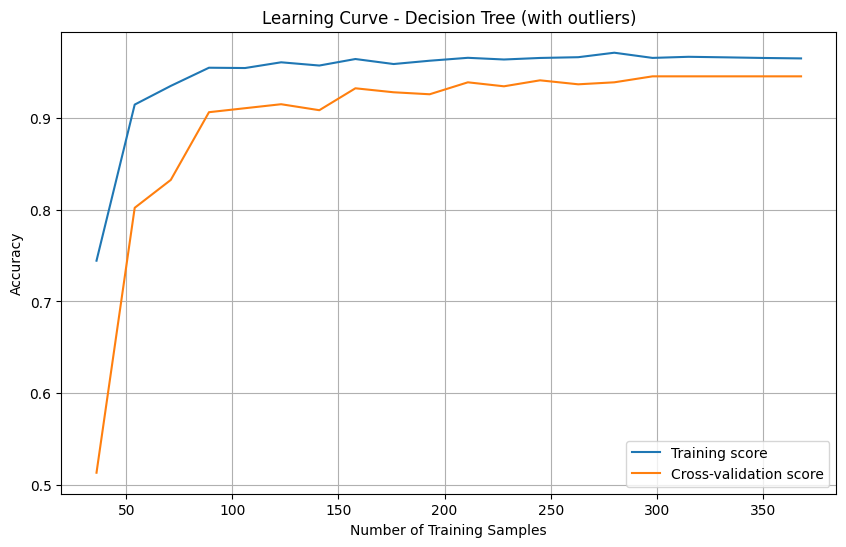

In [137]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curve - Decision Tree (with outliers)')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [138]:
fig.savefig("./plots/Final/Stratify/With outliers/Learning curve - Decision Tree.png")